# Try to fit resonances using two different models

## Model 1

### $ S_{21}(\nu) = |\frac{\sqrt{k_1 k_2}}{1 + k_1 + k_2 + iQ_0\delta}| $
### $\delta = \frac{\omega}{\omega_0} - \frac{\omega_0}{\omega}$

In [85]:
import emcee
import numpy as np
import corner
import matplotlib.pyplot as plt
import plot_settings
from scipy.linalg import det
from numpy import log, sqrt
from emcee.moves import StretchMove
from scipy.interpolate import interp1d

In [34]:
url = "https://raw.githubusercontent.com/biqute/QTLab2425/refs/heads/main/3Dqubit/data/empty_cavity_power_sweep/40mK_1.0kHz_-5dBm.csv"
data = np.loadtxt(url, delimiter=",", skiprows=1, usecols=(0, 1, 2), unpack=True)

In [35]:
F = data[0]
mag = np.abs(data[1] + 1j * data[2])

In [188]:
#F = (F - F[np.argmax(abs(mag))])*1e-6

magerr = np.ones_like(mag) * 0.0001
Ferr = np.ones_like(F) * 0.0001

err = np.sqrt(magerr**2 + Ferr**2)

sigma = np.sqrt(magerr[0]**2 + Ferr[0]**2)

Plot data

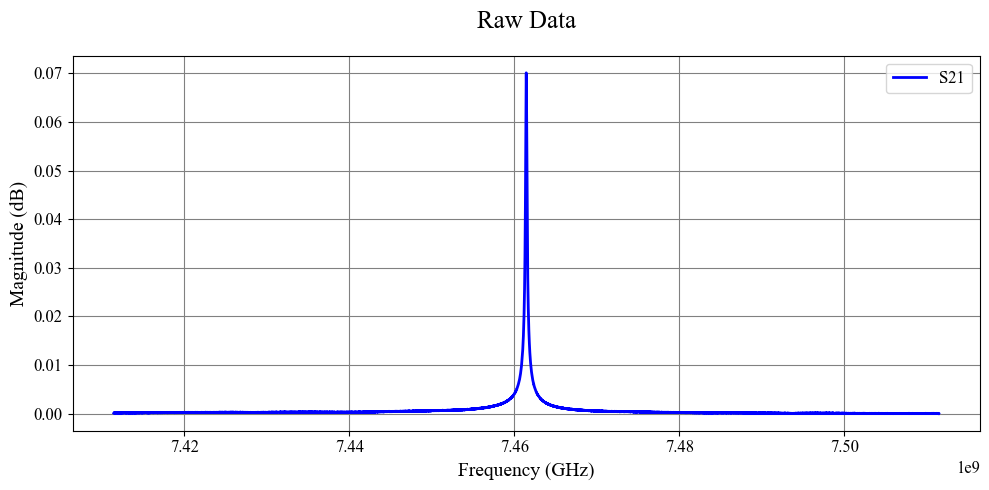

In [107]:
plt.plot(F, mag, label="S21", color='blue', linewidth=2)
plt.title("Raw Data")
plt.xlabel("Frequency (GHz)")
plt.ylabel("Magnitude (dB)")
plt.legend()

In [378]:
def model(x):
    
    k1, k2, Q0, nu0 = x
       
    num = 2 * np.sqrt(k1 * k2)
    alpha = np.where(F!=nu0, F/nu0 - nu0/F, 0)
    den =  1 + k1 + k2 + 1j * Q0 * alpha
            
    return np.abs(num/den)

def model_uncorr(x):
    
    ktot, beta, Q0, nu0 = x
    
    num = 2 * beta
    alpha = np.where(F!=nu0, F/nu0 - nu0/F, 0)
    den =  1 + ktot + 1j * Q0 * alpha
    
    return np.abs(num/den)

def compute_k1(k2):
    
    beta = (max(mag)/2)**2
    eps = 2 + k2 * (2 - 1/beta)
    if eps**2 - 4 * (2 * k2 + k2**2 +1) > 0:
        return 0.5 * (0-eps + np.sqrt(eps**2 - 4 * (2 * k2 + k2**2 +1)))
    else:
        return 0

def compute_Q0():
    
    A = 20*np.log10(mag)
    temp = A < max(A)-3
    return F[np.argmax(A)]/(min(F[np.where(F[temp] > F[np.argmax(A)])]) - max(F[np.where(F[temp] < F[np.argmax(A)])]))

In [ ]:
k2_est   = 0.02
k1_est   = compute_k1(k2_est)
Q0_est   = compute_Q0()
nu0_est  = F[np.argmax(mag)]+0.9*1e4

In [358]:
guess = np.array([k1_est, k2_est, Q0_est, nu0_est])

(7460000000.0, 7462500000.0)

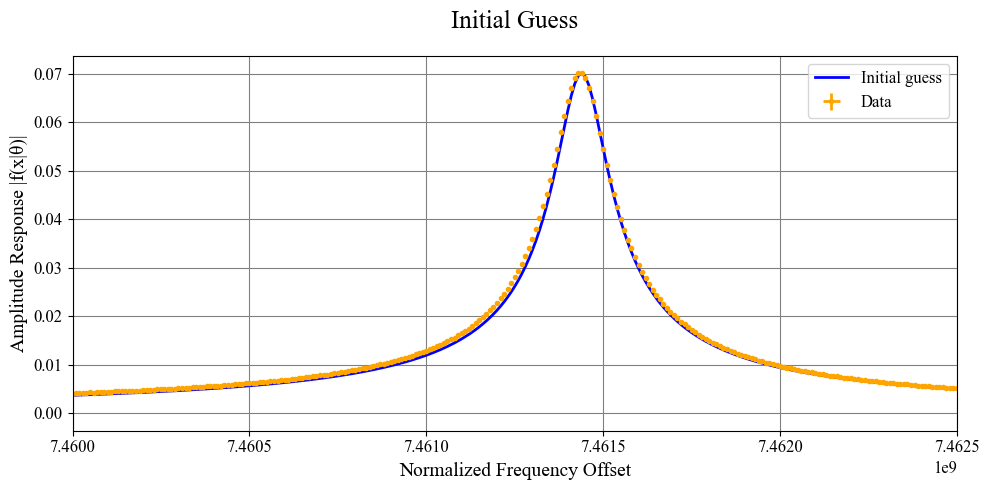

In [ ]:
plt.plot(F, model(guess),label="Initial guess", color='blue', markersize=5)
plt.errorbar(F, mag, xerr=Ferr, yerr=magerr,label="Data", color='orange', linewidth=2, fmt='.')
plt.title("Initial Guess")
plt.xlabel("Normalized Frequency Offset")
plt.ylabel("Amplitude Response |f(x|θ)|")
#plt.text(-1, 0.05, r"$k_1=8$, $k_2=0.05$, $Q_0=1e2$, $\nu_0=0.9e-2$", fontsize=12, color='black')
plt.legend()
plt.xlim(7.46*1e9, 7.4625*1e9)

In [398]:
k1_max = 100  * k1_est
k1_min = 0.01 * k1_est

k2_max = 10  * k2_est
k2_min = 0.1 * k2_est

Q0_max = 10  * Q0_est
Q0_min = 0.1 * Q0_est

nu0_max = 1.1  * nu0_est
nu0_min = 0.9  * nu0_est

ktot_min = k1_min+k2_min
ktot_max = k1_max+k2_max

beta_min = np.sqrt(k1_min * k2_min)
beta_max = np.sqrt(k1_max * k2_max)

In [399]:
# Log prior (uniform)
def log_prior(theta):
    k1, k2, Q0, omega0 = theta
    if k1_min < k1 < k1_max and k2_min < k2 < k2_max and Q0_min < Q0 < Q0_max and nu0_min < omega0 < nu0_max:
        return 0.0  # log(1)
    return -np.inf

def log_prior_uncorr(x):
    ktot, beta, Q0, nu0 = x
    if ktot_min < ktot < ktot_max and beta_min < beta < beta_max and Q0_min < Q0 < Q0_max and nu0_min < nu0 < nu0_max:
        return 0.0  # log(1)
    return -np.inf

In [400]:
def log_likelihood(x):
    y_model = model(x)
    return -0.5 * np.sum(((mag - y_model) / err) ** 2)

def log_likelihood_uncorr(x):
    y_model = model_uncorr(x)
    return -0.5 * np.sum(((mag - y_model) / err) ** 2)

In [401]:
def log_posterior(x):
    lp = log_prior(x)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(x)

def log_posterior_uncorr(x):
    lp = log_prior_uncorr(x)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_uncorr(x)

In [402]:
ndim     = 4  # number of parameters in the model
nwalkers = 20  # number of MCMC walkers
nsteps   = int(1e4)  # number of MCMC steps to take **for each walker**

In [365]:
guess_parameters = guess + np.random.randn(nwalkers, ndim) * 1e-5

In [366]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, moves=StretchMove(a=3.5))

In [367]:
sampler.run_mcmc(guess_parameters, nsteps);

In [ ]:
tau = sampler.get_autocorr_time()

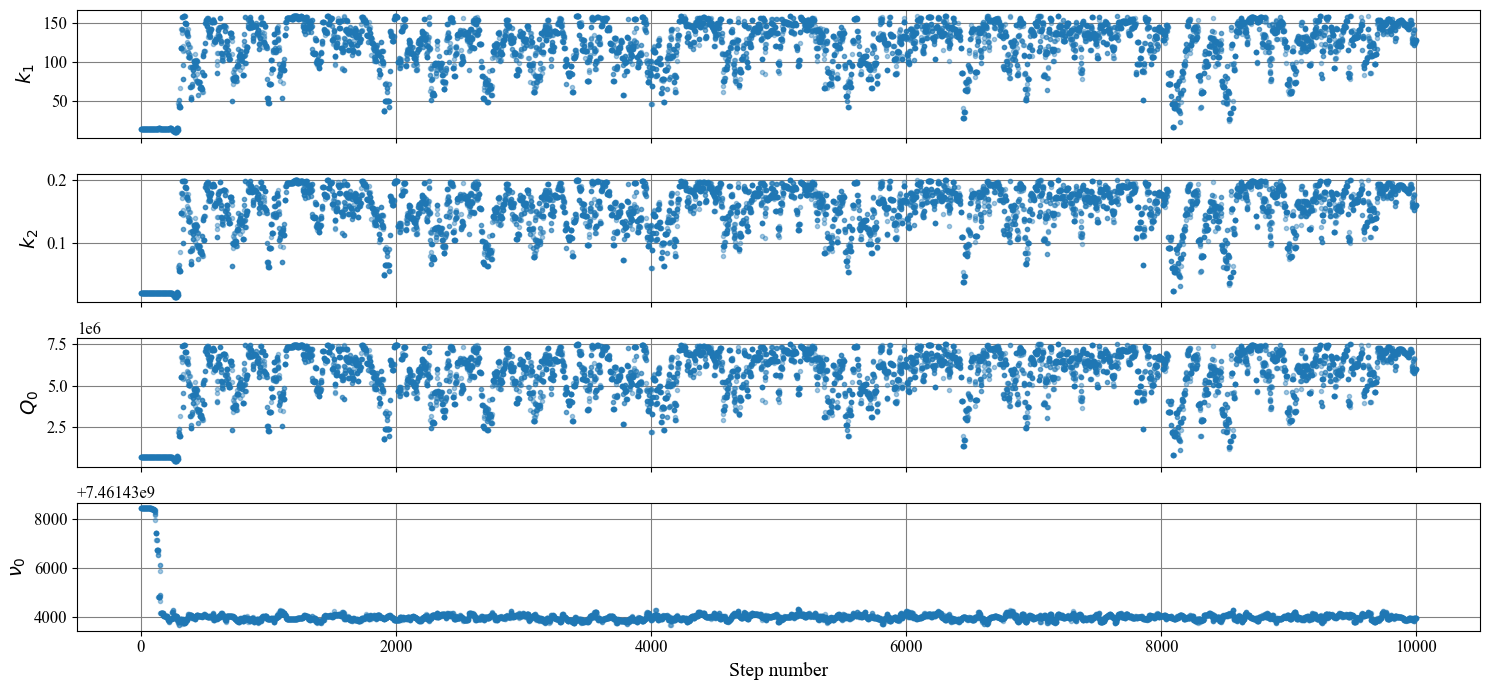

In [ ]:
labels = [r"$k_1$",r"$k_2$", r"$Q_0$", r"$\nu_0$"]
fig, axes = plt.subplots(ndim, figsize=(15, 7), sharex=True)

for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.get_chain()[:,0,i], '.',alpha=0.4)
    ax.set_ylabel(labels[i])
    ax.grid(True)
axes[-1].set_xlabel("Step number")
plt.tight_layout()


In [371]:
burn_idx = 2000

In [ ]:
burn_idx = 2000
samples = sampler.get_chain(flat=False, discard=burn_idx)
flat_samples = sampler.get_chain(flat=True, discard=burn_idx, thin=int(max(tau)))

In [ ]:
quantiles = np.array([16, 50, 95])

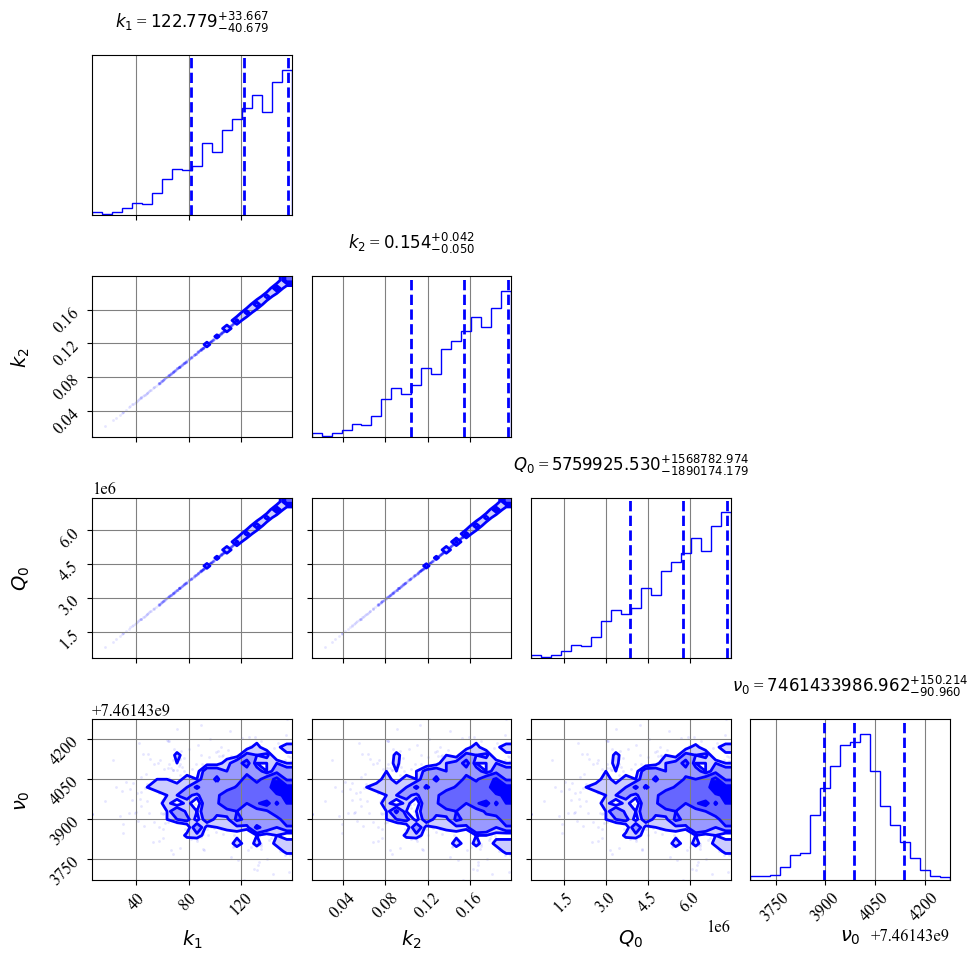

In [374]:
# Define true values (make sure vals is defined appropriately)
true_values = np.array([
    max(mag) / 2,
    np.mean(mag[:20]),
    0.2,
    50
])

# Generate corner plot
fig = corner.corner(
    flat_samples,
    labels=labels,  # customize these labels as needed
    truths=true_values,
    quantiles=quantiles*0.01,
    show_titles=True,
    title_fmt=".3f",              # Number format in titles
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 14},
    truth_color="darkred",
    color="blue",
    fill_contours=True
)

In [375]:
mcmc_estimates = np.percentile(flat_samples, q=quantiles, axis=0)

In [376]:
for i, name in enumerate(["$k_2$", "$Q_0$", r"$\omega_0$"]):
    q16, q50, q84 = mcmc_estimates[:, i]
    err_minus = q50 - q16
    err_plus = q84 - q50
    print(f"{name} = {q50:.4g} (+{err_plus:.2g}, -{err_minus:.2g})")

$k_2$ = 122.8 (+34, -41)
$Q_0$ = 0.1542 (+0.042, -0.05)
$\omega_0$ = 5.76e+06 (+1.6e+06, -1.9e+06)


(7460000000.0, 7462500000.0)

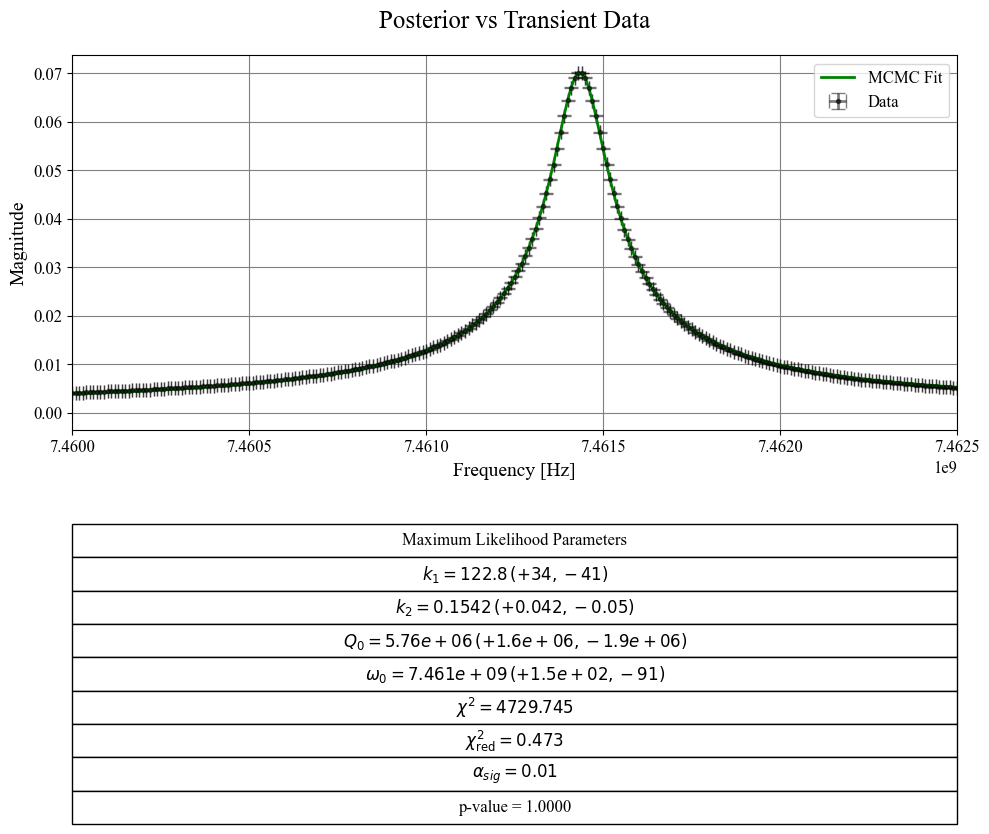

In [377]:
from scipy.stats import chi2 as CHI2
import matplotlib.pyplot as plt

# Median parameter estimates
k1_m, k2_m, Q0_m, omega0_m = mcmc_estimates[1]
params_median = np.array([k1_m, k2_m, Q0_m, omega0_m])

# Uncertainties (84th - 50th and 50th - 16th)
errs_plus = mcmc_estimates[2] - mcmc_estimates[1]
errs_minus = mcmc_estimates[1] - mcmc_estimates[0]

model_vals = model(mcmc_estimates[1])

# Compute chi-squared
chi2_val = -2 * log_likelihood(mcmc_estimates[1])
chi2_red = chi2_val / (len(mag) - 4)
p_val = CHI2.sf(chi2_val, len(mag) - 4)

# Plot
plt.figure(figsize=(10, 5))
plt.errorbar(F, mag, xerr=Ferr, yerr=magerr, capsize=5, fmt=".", label="Data", color='black', alpha=0.5)
plt.plot(F, model_vals, color='green', label="MCMC Fit", linewidth=2)

# Add table
cell_text = [
    [rf"$k_1 = {k1_m:.4g}\, (+{errs_plus[0]:.2g}, -{errs_minus[0]:.2g})$"],
    [rf"$k_2 = {k2_m:.4g}\, (+{errs_plus[1]:.2g}, -{errs_minus[1]:.2g})$"],
    [rf"$Q_0 = {Q0_m:.3g}\, (+{errs_plus[2]:.2g}, -{errs_minus[2]:.2g})$"],
    [rf"$\omega_0 = {omega0_m:.4g}\, (+{errs_plus[3]:.2g}, -{errs_minus[3]:.2g})$"],
    [rf"$\chi^2 = {chi2_val:.3f}$"],
    [rf"$\chi^2_\mathrm{{red}} = {chi2_red:.3f}$"],
    [rf"$\alpha_{{sig}} = 0.01$"],
    [rf"p-value = {p_val:.4f}"]
]

plt.table(cellText=cell_text,
          colLabels=["Maximum Likelihood Parameters"],
          loc='bottom', cellLoc='center',
          bbox=[0, -1.05, 1, 0.8],
          fontsize=12)

plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('Posterior vs Transient Data')
plt.legend()
plt.xlim(7.46e9, 7.4625e9)
#plt.tight_layout()


In [433]:
beta_est = np.sqrt(k1_est*k2_est)
ktot_est = k1_est + k2_est
Q0_est   = compute_Q0()
nu0_est  = F[np.argmax(mag)]+0.9*1e4

In [434]:
guess2 = np.array([ktot_est, beta_est, Q0_est, nu0_est])

(7460000000.0, 7462500000.0)

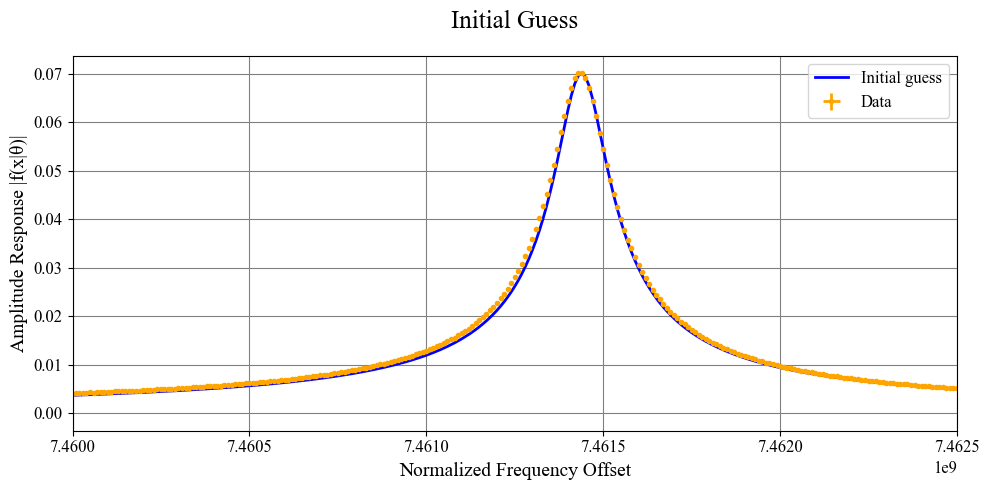

In [435]:
plt.plot(F, model_uncorr(guess2),label="Initial guess", color='blue', markersize=5)
plt.errorbar(F, mag, xerr=Ferr, yerr=magerr,label="Data", color='orange', linewidth=2, fmt='.')
plt.title("Initial Guess")
plt.xlabel("Normalized Frequency Offset")
plt.ylabel("Amplitude Response |f(x|θ)|")
#plt.text(-1, 0.05, r"$k_1=8$, $k_2=0.05$, $Q_0=1e2$, $\nu_0=0.9e-2$", fontsize=12, color='black')
plt.legend()
plt.xlim(7.46*1e9, 7.4625*1e9)

In [436]:
guess_parameters = guess2 + np.random.randn(nwalkers, ndim) * 1e-5

In [437]:
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_uncorr, moves=StretchMove(a=3.5))

In [438]:
sampler2.run_mcmc(guess_parameters, nsteps);

In [439]:
tau2 = sampler2.get_autocorr_time()

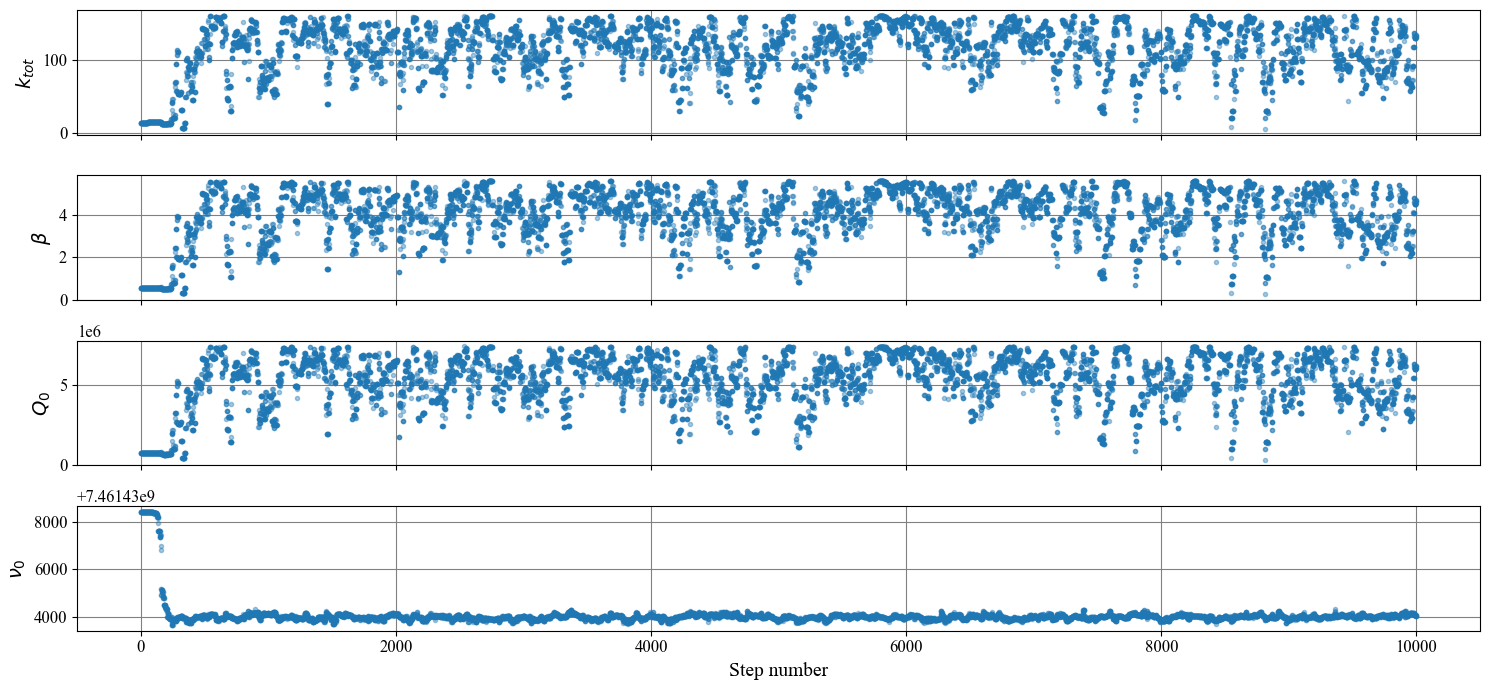

In [441]:
labels = [r"$k_{tot}$",r"$\beta$", r"$Q_0$", r"$\nu_0$"]
fig, axes = plt.subplots(ndim, figsize=(15, 7), sharex=True)

for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler2.get_chain()[:,0,i], '.',alpha=0.4)
    ax.set_ylabel(labels[i])
    ax.grid(True)
axes[-1].set_xlabel("Step number")
plt.tight_layout()

In [442]:
burn_idx = 2000

In [443]:
samples2 = sampler2.get_chain(flat=False, discard=burn_idx)
flat_samples2 = sampler2.get_chain(flat=True, discard=burn_idx, thin=int(max(tau)))

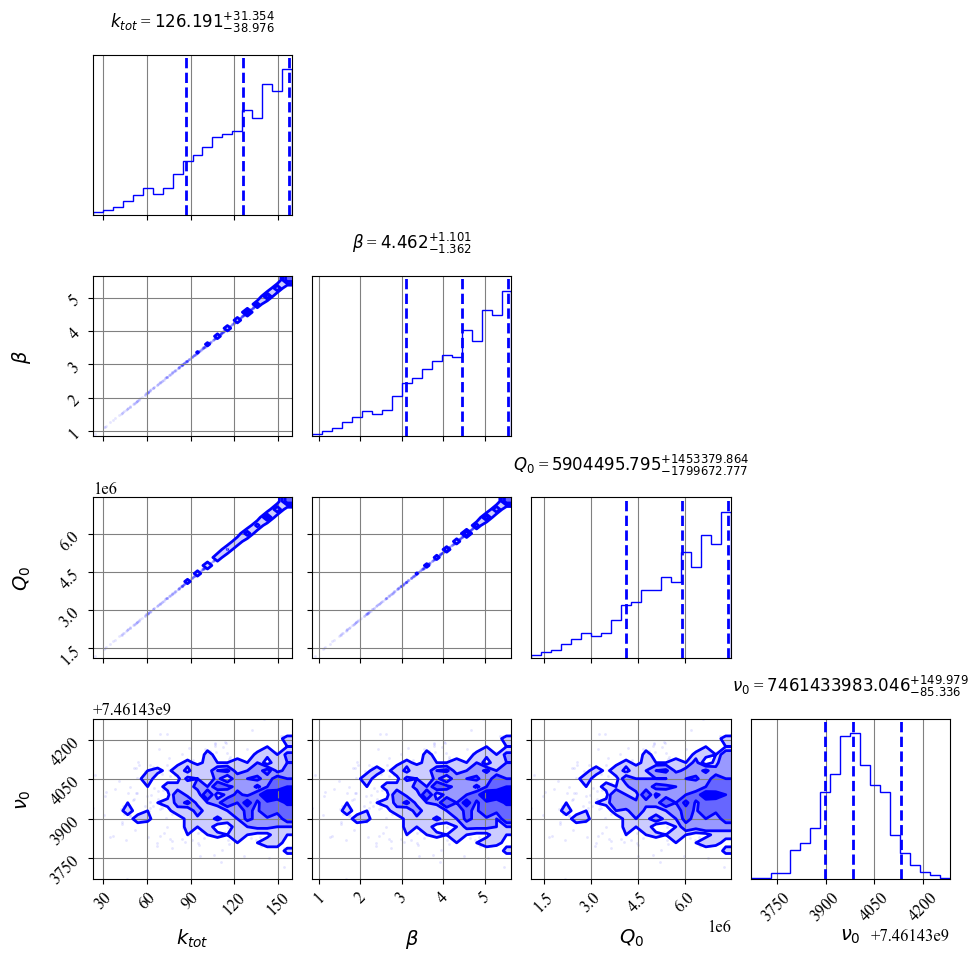

In [444]:
# Define true values (make sure vals is defined appropriately)
true_values = np.array([
    max(mag) / 2,
    np.mean(mag[:20]),
    0.2,
    50
])

# Generate corner plot
fig = corner.corner(
    flat_samples2,
    labels=labels,  # customize these labels as needed
    #truths=true_values,
    quantiles=quantiles*0.01,
    show_titles=True,
    title_fmt=".3f",              # Number format in titles
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 14},
    truth_color="darkred",
    color="blue",
    fill_contours=True
)

In [445]:
mcmc_estimates = np.percentile(flat_samples2, q=quantiles, axis=0)

In [446]:
for i, name in enumerate(["$k_2$", "$Q_0$", r"$\omega_0$"]):
    q16, q50, q84 = mcmc_estimates[:, i]
    err_minus = q50 - q16
    err_plus = q84 - q50
    print(f"{name} = {q50:.4g} (+{err_plus:.2g}, -{err_minus:.2g})")

$k_2$ = 126.2 (+31, -39)
$Q_0$ = 4.462 (+1.1, -1.4)
$\omega_0$ = 5.904e+06 (+1.5e+06, -1.8e+06)


(7460000000.0, 7462500000.0)

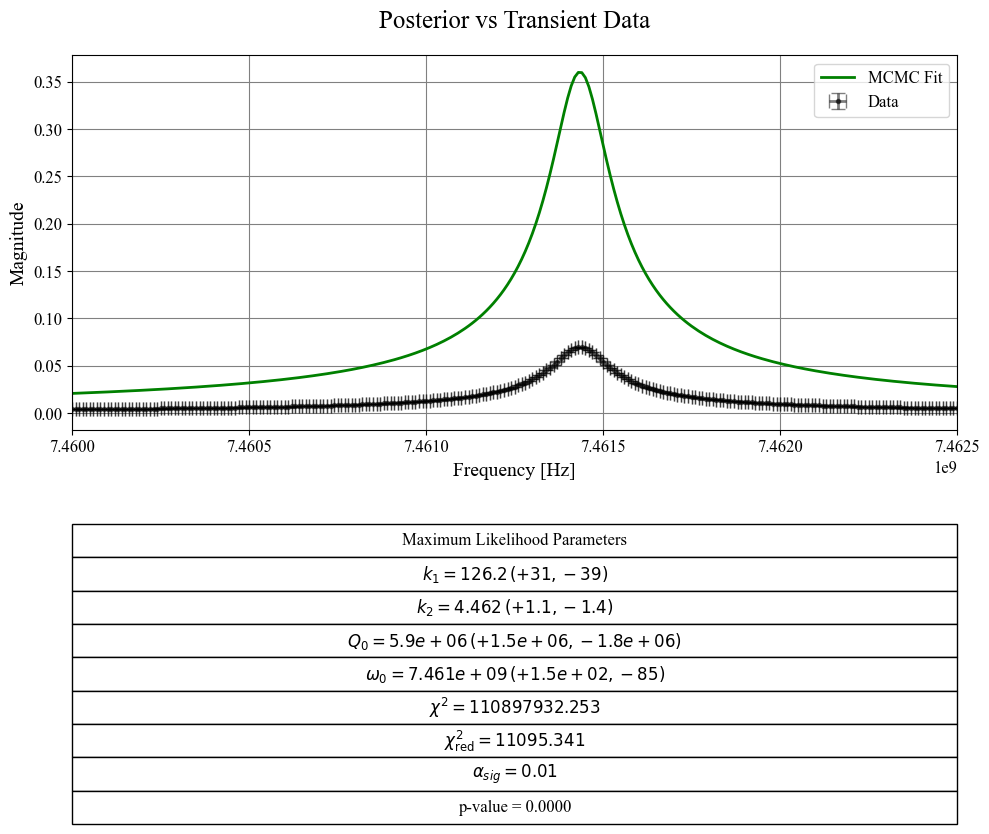

In [447]:
from scipy.stats import chi2 as CHI2
import matplotlib.pyplot as plt

# Median parameter estimates
k1_m, k2_m, Q0_m, omega0_m = mcmc_estimates[1]
params_median = np.array([k1_m, k2_m, Q0_m, omega0_m])

# Uncertainties (84th - 50th and 50th - 16th)
errs_plus = mcmc_estimates[2] - mcmc_estimates[1]
errs_minus = mcmc_estimates[1] - mcmc_estimates[0]

model_vals = model(mcmc_estimates[1])

# Compute chi-squared
chi2_val = -2 * log_likelihood(mcmc_estimates[1])
chi2_red = chi2_val / (len(mag) - 4)
p_val = CHI2.sf(chi2_val, len(mag) - 4)

# Plot
plt.figure(figsize=(10, 5))
plt.errorbar(F, mag, xerr=Ferr, yerr=magerr, capsize=5, fmt=".", label="Data", color='black', alpha=0.5)
plt.plot(F, model_vals, color='green', label="MCMC Fit", linewidth=2)

# Add table
cell_text = [
    [rf"$k_1 = {k1_m:.4g}\, (+{errs_plus[0]:.2g}, -{errs_minus[0]:.2g})$"],
    [rf"$k_2 = {k2_m:.4g}\, (+{errs_plus[1]:.2g}, -{errs_minus[1]:.2g})$"],
    [rf"$Q_0 = {Q0_m:.3g}\, (+{errs_plus[2]:.2g}, -{errs_minus[2]:.2g})$"],
    [rf"$\omega_0 = {omega0_m:.4g}\, (+{errs_plus[3]:.2g}, -{errs_minus[3]:.2g})$"],
    [rf"$\chi^2 = {chi2_val:.3f}$"],
    [rf"$\chi^2_\mathrm{{red}} = {chi2_red:.3f}$"],
    [rf"$\alpha_{{sig}} = 0.01$"],
    [rf"p-value = {p_val:.4f}"]
]

plt.table(cellText=cell_text,
          colLabels=["Maximum Likelihood Parameters"],
          loc='bottom', cellLoc='center',
          bbox=[0, -1.05, 1, 0.8],
          fontsize=12)

plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('Posterior vs Transient Data')
plt.legend()
plt.xlim(7.46e9, 7.4625e9)
#plt.tight_layout()
